In [30]:
import pandas as pd
import numpy as np
import os
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
pd.set_option('display.max_rows', 50)

In [31]:
def clean_row(row):
    html = row["original_info"]
    soup = BeautifulSoup(html, 'html.parser')
    #the date is in <div class="smalltext">
    date = soup.find("div", {"class": "smalltext"}).text
    #if the date contains "Last edit: ", use that instead
    if "Last edit:" in date:
        date = date.split("Last edit: ")[1]
    if " by " in date:
        date = date.split(" by ")[0]
    #delete <div class="quote">
    for quote in soup.find_all("div", {"class": "quote"}):
        quote.decompose()
    for quote in soup.find_all("div", {"class": "quoteheader"}):
        quote.decompose()
    #post is in <div class="post">
    post = soup.find("div", {"class": "post"}).text
    #remove all links
    post = re.sub(r'http\S+', '<link>', post)
    #remove duplicate spaces
    post = re.sub(' +', ' ', post)
    #remove all non-ascii characters
    post = post.encode("ascii", errors="ignore").decode()
    #remove all words that have a length above 20 (most likely a btc address or something useless)
    post = " ".join([(word if len(word) < 20 else "<truncated>") for word in post.split()])

    return post, date

In [32]:
def process_files(files, folder):
    chunk_df = pd.DataFrame()
    for file in tqdm(files):
        df2 = pd.read_csv(os.path.join(folder, file))
        df2["original_info"] = df2["original_info"].astype(str)

        # Each file is a thread, we only need the first 3 posts in a thread
        post = ""
        date = ""
        for (i,row) in enumerate(df2.iterrows()):
            post_, date_ = clean_row(row[1])
            post += post_ + "<sep>"
            date += date_ + "<sep>"
            if i == 2:
                break
        post = post[:-5]
        date = date[:-5]

        topic = df2.iloc[0]["topic"]
        df3 = pd.DataFrame({"topic": topic,"date": date,"post": post}, index=[0])
        chunk_df = pd.concat([chunk_df, df3], axis=0)
    return chunk_df

def split_into_chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

folder = "../../scraper/data/Bitcoin"
csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]

# Determine the size of each chunk
num_chunks = 100
n = len(csv_files) // num_chunks + (1 if len(csv_files) % num_chunks > 0 else 0)

# Split files into 10 chunks
chunks = list(split_into_chunks(csv_files, n))

# Process each chunk and collect the resulting DataFrames
chunk_dfs = [process_files(chunk, folder) for chunk in chunks]#[:2]

# Merge all chunk DataFrames into one large DataFrame
df = pd.concat(chunk_dfs, axis=0).reset_index(drop=True)

print(df)

  0%|          | 0/612 [00:00<?, ?it/s]

100%|██████████| 524/524 [00:02<00:00, 224.81it/s]

                                                   topic  \
0      [OLD THREAD] Bitcoin version 0.2 development s...   
1                         Bitcoin Better Business Bureau   
2                                   3 stages for bitcoin   
3                  The 25 most exciting bitcoin startups   
4      Nasdaq to Provide Trading Technology for Bitco...   
...                                                  ...   
61107  Representative Mark Warden Utilizing Bitcoin f...   
61108  Ok So I Just Sent £1000 of BTC to a Friend in ...   
61109              We have been entertained and educated   
61110  Can anyone think of a good kind of game that w...   
61111  This Week in Bitcoin (March 15-22): Coinarch W...   

                                                    date  \
0      October 09, 2011, 07:33:02 PM<sep>December 01,...   
1      August 12, 2012, 04:17:16 AM<sep>August 12, 20...   
2      March 23, 2015, 05:02:42 PM<sep>March 23, 2015...   
3      March 23, 2015, 08:13:42 PM<sep>

In [33]:
df.to_csv("concat.csv", index=False)

In [72]:
df = pd.read_csv("concat.csv")

In [73]:
#shorten df to test code
# df = df.sample(300)

In [74]:
df

,topic,date,post
0,[OLD THREAD] Bitcoin version 0.2 development s...,"October 09, 2011, 07:33:02 PM<sep>December 01,...",We've been working hard on improvements for th...
1,Bitcoin Better Business Bureau,"August 12, 2012, 04:17:16 AM<sep>August 12, 20...",Here's an idea I had while mowing the lawn thi...
2,3 stages for bitcoin,"March 23, 2015, 05:02:42 PM<sep>March 23, 2015...","XAPO CEO, roadmap <link><sep>It is interesting..."
3,The 25 most exciting bitcoin startups,"March 23, 2015, 08:13:42 PM<sep>March 23, 2015...",<link> the readknew of all of themhope you enj...
4,Nasdaq to Provide Trading Technology for Bitco...,"March 23, 2015, 08:33:11 PM<sep>March 23, 2015...",Nasdaq OMX Group Inc. has agreed to provide Ne...
...,...,...,...
61107,Representative Mark Warden Utilizing Bitcoin f...,"August 11, 2012, 08:26:47 PM<sep>August 11, 20...",Mark Warden is releasing this press release in...
61108,Ok So I Just Sent £1000 of BTC to a Friend in ...,"March 22, 2015, 10:42:01 PM<sep>March 22, 2015...","OK, So I just sent 1000 of Bitcoin to a friend..."
61109,We have been entertained and educated,"March 22, 2015, 11:14:20 PM<sep>March 22, 2015...",If Bitcoin goes on to fail (which is very very...
61110,Can anyone think of a good kind of game that w...,"March 22, 2015, 11:24:28 PM<sep>1711031959<sep...",<link> Ref a name for cryptographic currency -...


In [75]:
test_row = df.iloc[0]
print(test_row["post"])
print(test_row["date"])
print(test_row["topic"])

We've been working hard on improvements for the next version release. Martti (sirius-m) added some nice features to make it more user friendly and easier to run in the background:- Minimize to system tray option- Autostart on boot option so you can keep it running in the background automatically- New options dialog layout- Setup EXE for Windows, in addition to the archive downloadI've been working on a number of refinements to the networking code and laying the groundwork for future functionality. Also coming in version 0.2:- Multi-processor support for coin generation- Proxy support<sep>Wouldn't it be funny if Satoshi had written "Also coming in version <truncated><sep>Although I wasn't around that early I can still recall the spirit of Bitcoin's early days when it was mainly experimentation and fun with much less emphasis put on the exchange rate, because most users had understood, yet not internalized (emotionally) that Bitcoin is money. So coins were much more likely to be through 

In [76]:
# df = df[['topic', 'post', 'date']]
# # replace "Today at " with "October 1, 2023, "
# df["date"] = df["date"].str.replace("Today at ", "March 27, 2024, ")
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values(by=["date"])
# #remove "Re: " from topic
# df["topic"] = df["topic"].str.replace("Re: ", "")
# df

In [77]:
# # group by topic and append all the strings from the post column
# df["date"] = df["date"].astype(str)
# df = df.groupby('topic').agg({'post': '<sep>'.join, 'date': '<sep>'.join}).reset_index()

In [78]:
df["dates"] = df["date"]

In [79]:
for i in range(len(df)):
    s = df.iloc[i]["dates"]
    last_date = s.split("<sep>")[0].replace("Today at ", "March 27, 2024, ")
    try:
        # format is October 31, 2011, 06:32:31 PM
        last_date = pd.to_datetime(last_date, format='%B %d, %Y, %I:%M:%S %p')
        df["date"].iloc[i] = last_date
    except:
        print("Error with date: ", s)

df = df.sort_values(by=["date"])

In [83]:
df = df.reset_index(drop=True)

In [84]:
df

,topic,date,post,dates
0,Welcome to the new Bitcoin forum!,2009-11-22 18:04:28,Welcome to the new Bitcoin forum!The old forum...,"November 22, 2009, 06:04:28 PM<sep>February 02..."
1,Repost: Bitcoin Maturation,2009-11-22 18:31:44,"<truncated> <truncated> 01 of Oct, 2009 (14:12...","November 22, 2009, 06:31:44 PM<sep>July 27, 20..."
2,Repost: Request: Make this anonymous?,2009-11-22 18:32:00,"<truncated> Make this <truncated> 15 of Oct, 2...","November 22, 2009, 06:32:00 PM<sep>February 06..."
3,Repost: How anonymous are bitcoins?,2009-11-25 18:15:57,<truncated> anonymous are bitcoins?Can nodes o...,"November 25, 2009, 06:15:57 PM<sep>August 19, ..."
4,Repost: Linux/UNIX compile,2009-11-27 17:17:22,"<truncated> compilePosted:Thu 08 of Oct, 2009 ...","November 27, 2009, 05:17:22 PM<sep>June 19, 20..."
...,...,...,...,...
61107,~~~When did you first heard about bitcoin 2024...,2024-03-18 16:36:39,So we have around 1 month left for the 4th hal...,"March 18, 2024, 04:36:39 PM<sep>March 18, 2024..."
61108,BTC spot ETF: Wall Street's Trojan horse,2024-03-19 01:07:43,The concept of tokenization has been around si...,"March 19, 2024, 01:07:43 AM<sep>March 19, 2024..."
61109,Contest: Predict the exact possible bitcoin pr...,2024-03-19 15:21:37,I had some merits lying around with me for som...,"March 19, 2024, 03:21:37 PM<sep>March 19, 2024..."
61110,"MicroStrategy acquires an additional 9,245 BTC...",2024-03-19 20:56:10,"As of 3/18/24, $MSTR holds 214,246 $BTC acquir...","March 19, 2024, 08:56:10 PM<sep>March 19, 2024..."


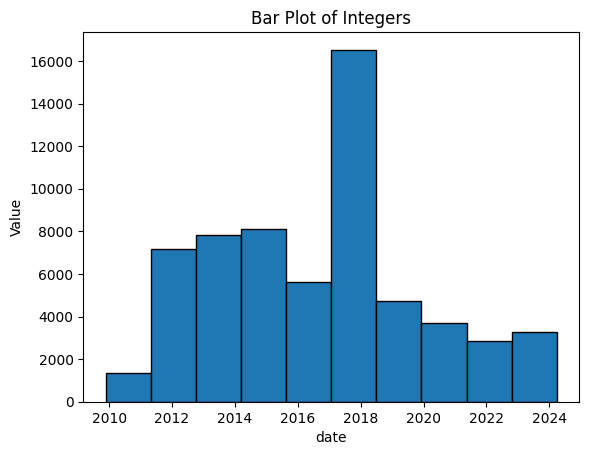

In [86]:
import matplotlib.pyplot as plt
plt.hist(df["date"], bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('date')
plt.ylabel('Value')
plt.title('Bar Plot of Integers')

# Show the plot
plt.show()

# print(df["start_edit"].max())
# print(df["start_edit"].min())

In [88]:
df.to_csv("cleaned-data.csv", index=False)